In [3]:
import warnings
warnings.filterwarnings('ignore')


In [4]:
%matplotlib inline

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import seaborn as sns

from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import minmax_scale
from scipy.stats import probplot, moment
from sklearn.metrics import mean_absolute_error

In [5]:
sns.set(style='whitegrid',
        context='notebook',
        color_codes=True)

In [6]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Time Series')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [7]:
def test_unit_root(df):
    return df.apply(lambda x: f'{pd.Series(adfuller(x)).iloc[1]:.2%}').to_frame('p-value')

In [8]:
sent = 'UMCSENT'
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1970', '2019-12').dropna()
df.columns = ['sentiment', 'ip']

In [9]:

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 528 entries, 1972-02-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  528 non-null    float64
 1   ip         528 non-null    float64
dtypes: float64(2)
memory usage: 12.4 KB


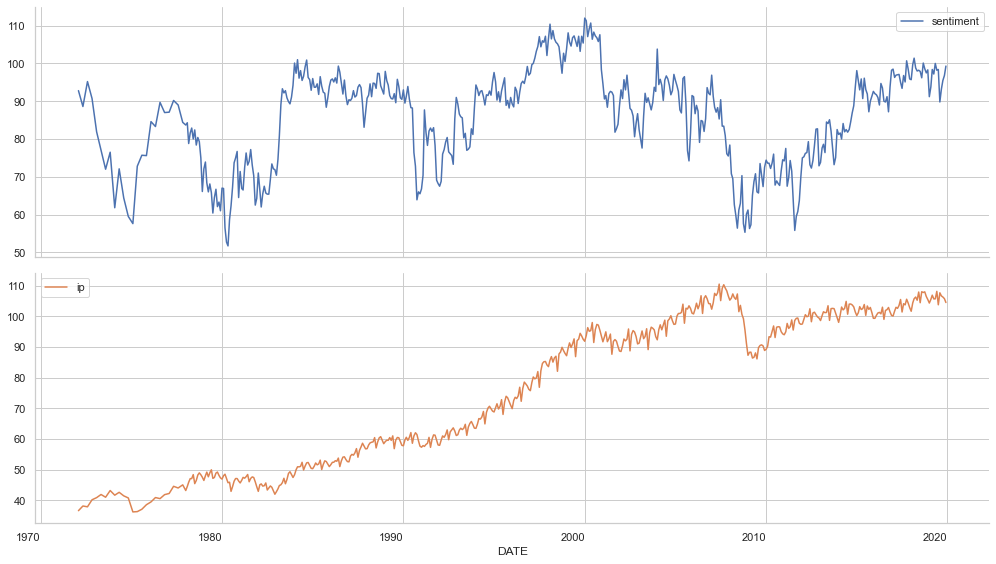

In [10]:
df.plot(subplots=True, figsize=(14,8), rot=0)
sns.despine()
plt.tight_layout();

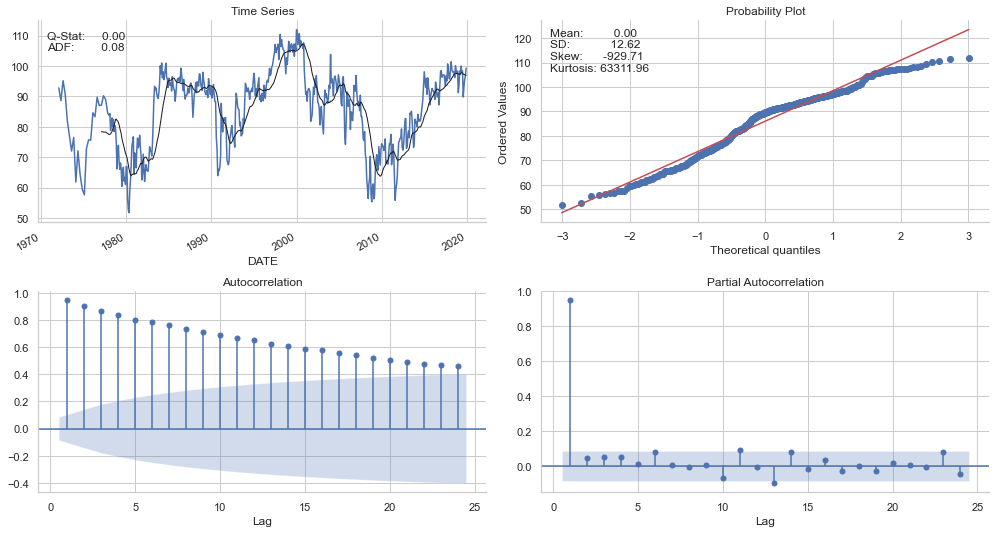

In [11]:
plot_correlogram(df.sentiment, lags=24)

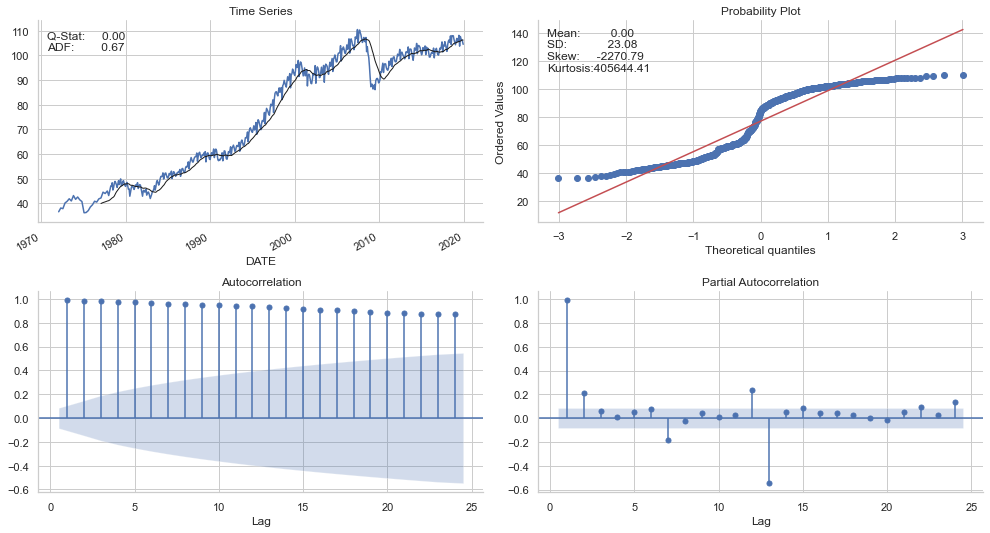

In [12]:

plot_correlogram(df.ip, lags=24)

In [13]:
df_transformed = pd.DataFrame({'ip': np.log(df.ip).diff(12),
                              'sentiment': df.sentiment.diff(12)}).dropna()

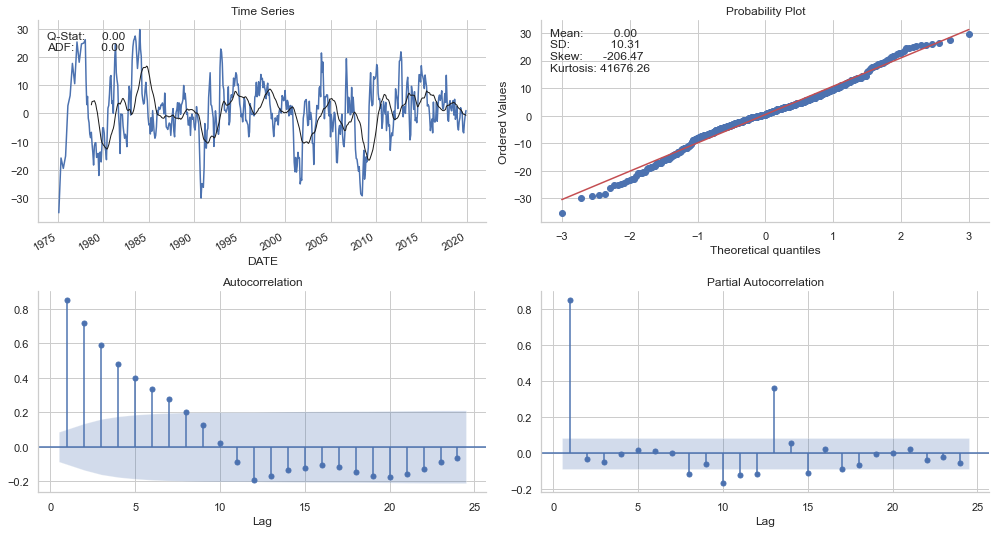

In [14]:

plot_correlogram(df_transformed.sentiment, lags=24)

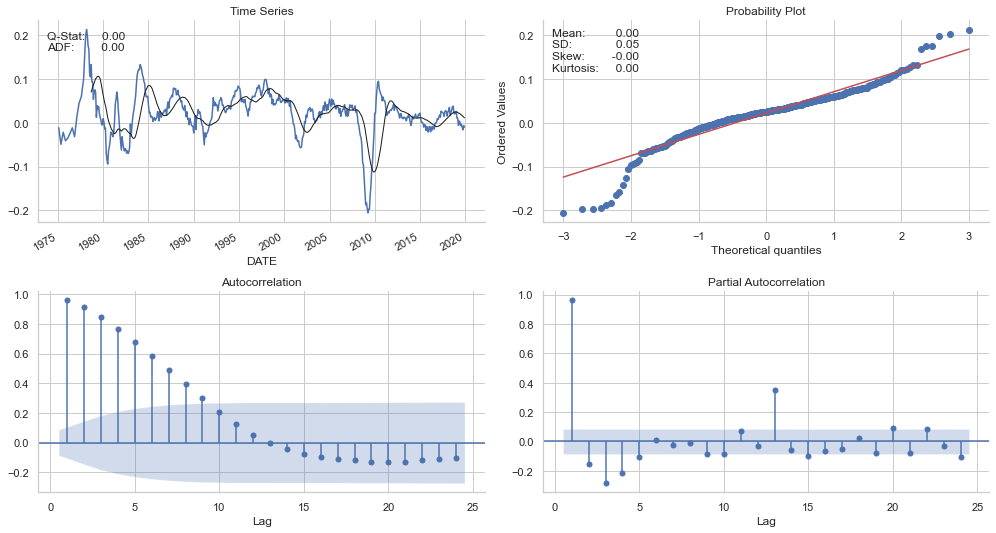

In [15]:
plot_correlogram(df_transformed.ip, lags=24)


In [16]:
test_unit_root(df_transformed)

,p-value
ip,0.02%
sentiment,0.00%


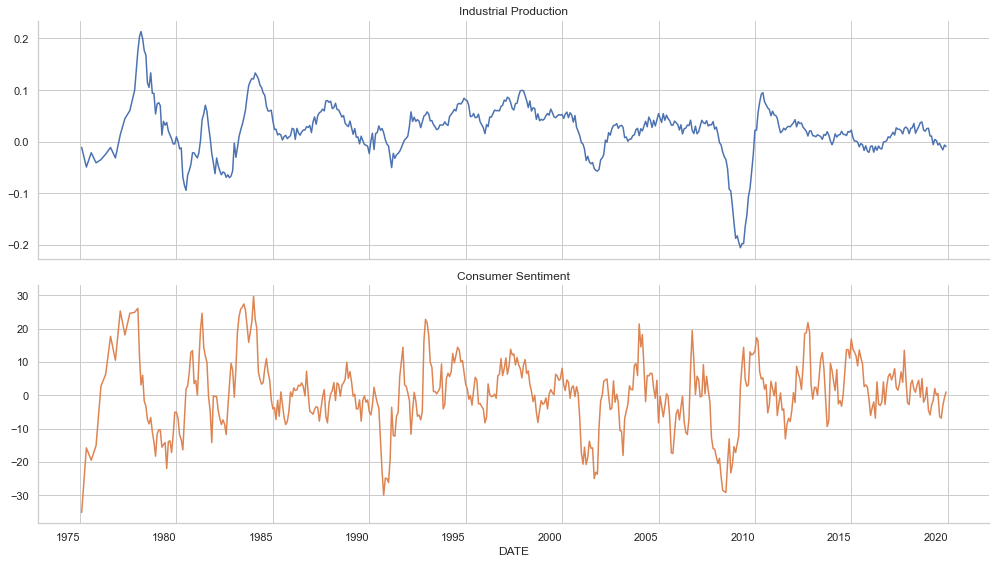

In [17]:
df_transformed.plot(subplots=True, figsize=(14, 8),
                    title=['Industrial Production', 'Consumer Sentiment'],
                    legend=False,
                    rot=0)
sns.despine()
plt.tight_layout()


In [18]:
df_transformed = df_transformed.apply(minmax_scale)

In [19]:
model = VARMAX(df_transformed.loc[:'2017'], order=(1,1), trend='c').fit(maxiter=1000)

C:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [20]:
print(model.summary())

                            Statespace Model Results                           
Dep. Variable:     ['ip', 'sentiment']   No. Observations:                  492
Model:                      VARMA(1,1)   Log Likelihood                1560.335
                           + intercept   AIC                          -3094.669
Date:                 Mon, 22 Feb 2021   BIC                          -3040.089
Time:                         10:57:53   HQIC                         -3073.237
Sample:                              0                                         
                                 - 492                                         
Covariance Type:                   opg                                         
Ljung-Box (L1) (Q):             0.15, 0.29   Jarque-Bera (JB):        151.67, 16.67
Prob(Q):                        0.70, 0.59   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.46, 1.03   Skew:                       0.19, 0.21
Prob(H) (two-sided):        

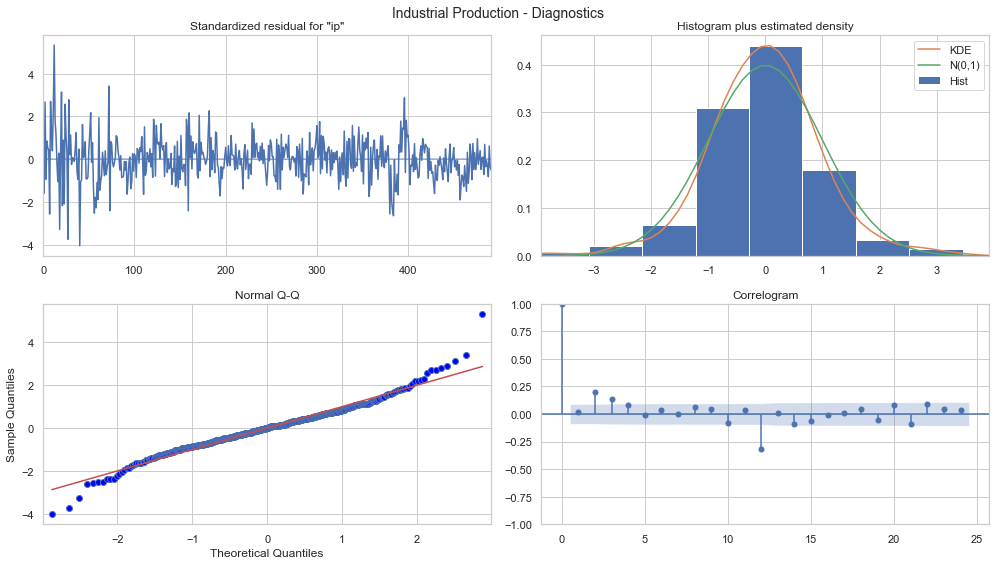

In [21]:
model.plot_diagnostics(variable=0, figsize=(14,8), lags=24)
plt.gcf().suptitle('Industrial Production - Diagnostics', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=.93);

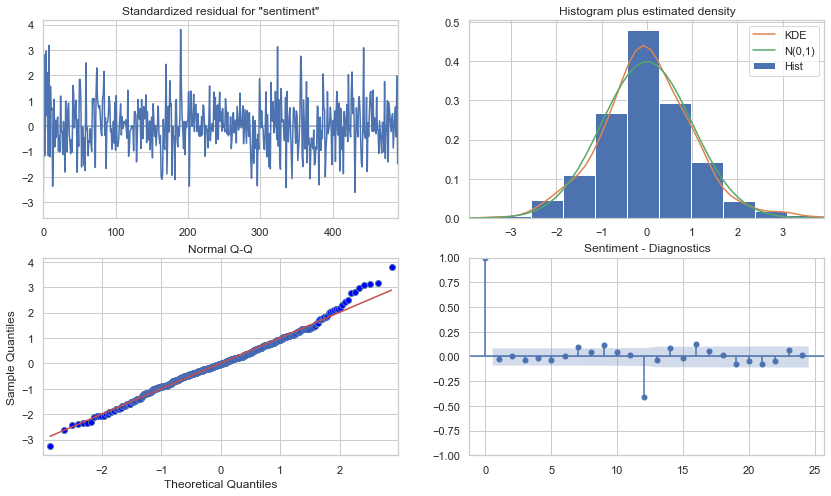

In [22]:
model.plot_diagnostics(variable=1, figsize=(14,8), lags=24)
plt.title('Sentiment - Diagnostics');

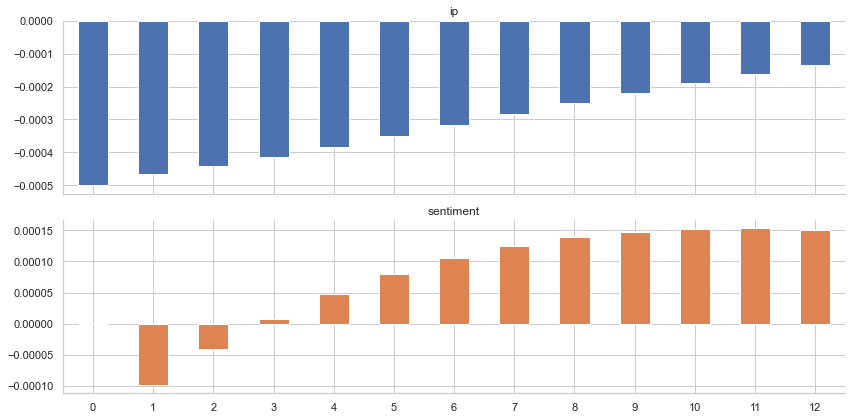

In [23]:
median_change = df_transformed.diff().quantile(.5).tolist()
model.impulse_responses(steps=12,
                        impulse=median_change).plot.bar(subplots=True,
                                                        figsize=(12, 6),
                                                        rot=0,
                                                        legend=False)
sns.despine()
plt.tight_layout()

In [24]:
n =len(df_transformed)
start = n-24

preds = model.predict(start=start+1, end=n)

C:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


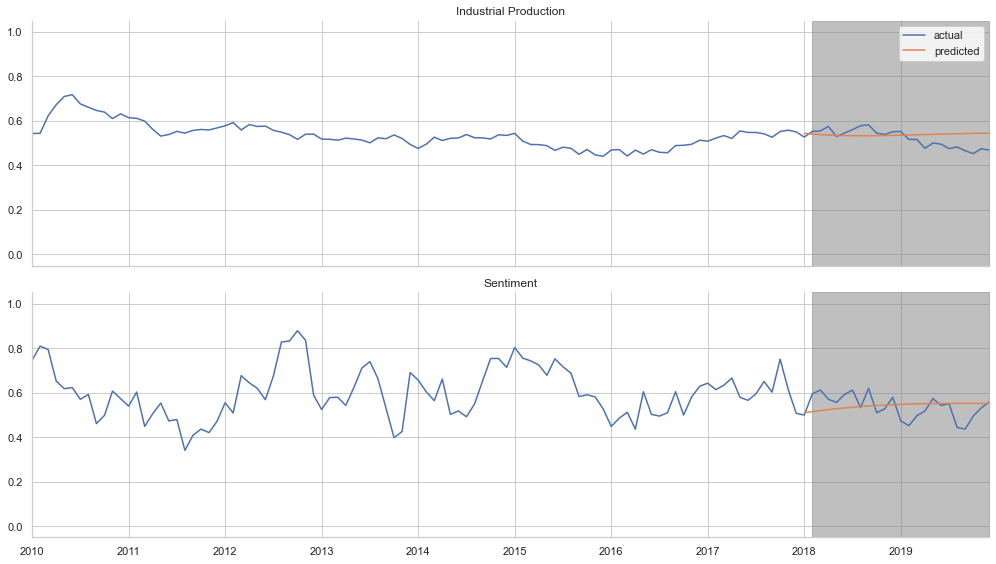

In [25]:
preds.index = df_transformed.index[start:]

fig, axes = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)

df_transformed.ip.loc['2010':].plot(ax=axes[0], label='actual', title='Industrial Production')
preds.ip.plot(label='predicted', ax=axes[0])
trans = mtransforms.blended_transform_factory(axes[0].transData, axes[0].transAxes)
axes[0].legend()
axes[0].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)

trans = mtransforms.blended_transform_factory(axes[0].transData, axes[1].transAxes)
df_transformed.sentiment.loc['2010':].plot(ax=axes[1], label='actual', title='Sentiment')
preds.sentiment.plot(label='predicted', ax=axes[1])
axes[1].fill_between(x=df_transformed.index[start+1:], y1=0, y2=1, transform=trans, color='grey', alpha=.5)
axes[1].set_xlabel('')
sns.despine()
fig.tight_layout();

In [26]:
forecast = model.forecast(steps=24)

C:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


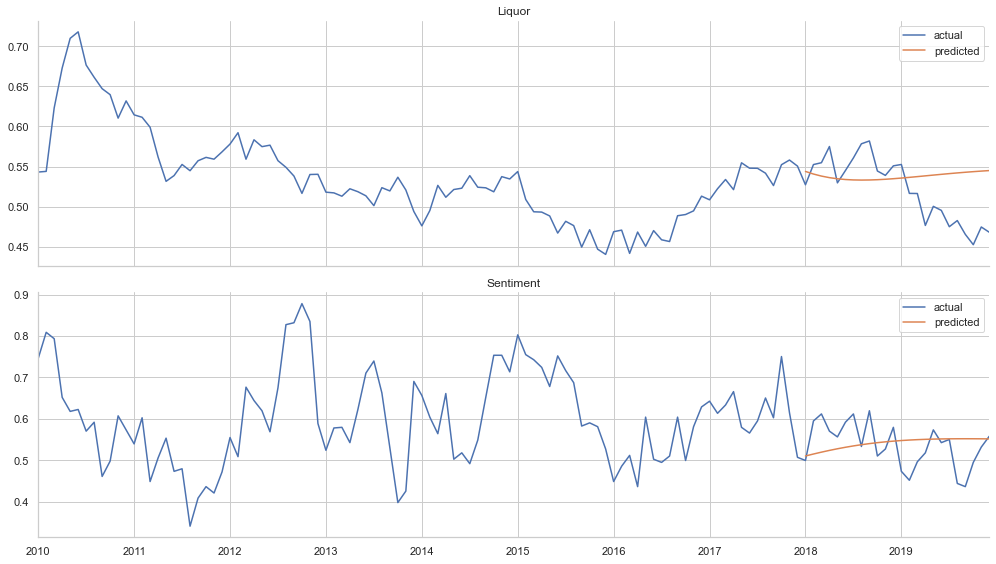

In [27]:
fig, axes = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)

df_transformed['2010':].ip.plot(ax=axes[0], label='actual', title='Liquor')
preds.ip.plot(label='predicted', ax=axes[0])
axes[0].legend()

df_transformed['2010':].sentiment.plot(ax=axes[1], label='actual', title='Sentiment')
preds.sentiment.plot(label='predicted', ax=axes[1])
axes[1].legend()
axes[1].set_xlabel('')
sns.despine()
fig.tight_layout();

In [28]:
mean_absolute_error(forecast, df_transformed.iloc[492:])


0.0428565439896947